In [1]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# %pip install understatapi
from understatapi import UnderstatClient

YEAR = '2021'
LEAGUE = 'EPL'

# get data for every player playing in the Premier League in 2019/20


In [2]:
def process_shot_data(player_shot_data):
    for shot in player_shot_data:
        shot['ScoredEarlier']=0
        shot['ScoredPenEarlier']=0
        shot['ScoredLater']=0
        shot['ScoredPenLater']=0
        shot['PrevAccumXG']=0.0

        # if shot['a_goals']==shot['h_goals']:
        #     shot['State']='tied'
        # elif (shot['a_goals']>shot['h_goals'] and shot['h_a']=='a') or (shot['a_goals']<shot['h_goals'] and shot['h_a']=='h'):
        #     shot['State']='winning'
        # else:
        #     shot['State']='losing'
        # ovo ne radi jer H_GOALS i A_GOALS prikazuju rezultat na kraju, a ne u trenutku suta.
        
        if(shot['result']=='Goal'):
            shot['IsGoal']=True
        else:
            shot['IsGoal']=False


    for i in range(len(player_shot_data)):
        shot = player_shot_data[i]
        original_date = (shot['date'].split()[0])
        if(shot['result']=='Goal'):
            j=i+1
            while  j<len(player_shot_data) and player_shot_data[j]['date'].split()[0] == original_date:
                player_shot_data[j]['ScoredEarlier']=1
                j+=1
            
            
            j=i-1
            while player_shot_data[j]['date'].split()[0] == original_date and j>=0:
                player_shot_data[j]['ScoredLater']=1
                j-=1

    if(len(player_shot_data)==0): return
    prev_date = (player_shot_data[0]['date'].split()[0])
    accum_xG = 0.0 
    for i in range(len(player_shot_data)):
        shot = player_shot_data[i]
        shot['PrevAccumXG']=accum_xG
        accum_xG+=float(shot['xG'])
        if shot['date'].split()[0] != prev_date:
            accum_xG = 0.0
            prev_date = shot['date'].split()[0]

        
        # print(shot['date'].split()[0])
        # print(shot['minute'])




In [3]:
def prepare_one_dataframe(YEAR, LEAGUE):
    understat = UnderstatClient()
    league_player_ids = set()
    league_player_data = understat.league(league=LEAGUE).get_player_data(season=YEAR)
    league_player_ids.update( [player['id'] for player in league_player_data])

    all_player_shot_data = []
    for player_id in league_player_ids:
        shot_data = understat.player(player=player_id).get_shot_data()
        process_shot_data(shot_data)
        all_player_shot_data+=shot_data





    from heapq import merge


    match_shots = [understat.match(match_info['id']).get_shot_data() for match_info in understat.league(LEAGUE).get_match_data(season = YEAR)]

    all_match_shot_data = []

    for i in range(len(match_shots)):
        team_dic = match_shots[i]
        match=list(merge(team_dic['a'], team_dic['h'], key=lambda shot : int(shot['minute'])))

        home_goals_so_far=0
        away_goals_so_far=0
        for shot in match:
            if shot['h_a']=='h':
                shot['MyScore']=home_goals_so_far
                shot['OppScore']=away_goals_so_far
            else:
                shot['MyScore']=away_goals_so_far
                shot['OppScore']=home_goals_so_far

            if shot['result']=='Goal':
                if shot['h_a']=='h':
                    home_goals_so_far+=1
                else:
                    away_goals_so_far+=1
        match_shots[i]=match
        all_match_shot_data+=match



    matchshotdf = pd.DataFrame(all_match_shot_data).set_index('id')
    matchshotdf.head(10)
    shotdf = pd.DataFrame(all_player_shot_data)
    shotdf['PrevAccumXG'].head(20)
    #shotdf.to_csv(f'../data/shotdf_without_betting_before_processing_{YEAR}_{LEAGUE}.csv')
    shotdf = shotdf[ shotdf['season'] == YEAR ].set_index('id')

    # print(shotdf.head(10),
    # matchshotdf[['MyScore','OppScore']].head(10))
    matchshotdf = matchshotdf[['MyScore','OppScore']]
    #matchshotdf.to_csv(f'../data/scores_{YEAR}_{LEAGUE}.csv')
    shotdf = shotdf.join(matchshotdf, how='inner')

    # shotdf['minute'] = shotdf['minute'].apply(int)
    # shotdf['xG'] = shotdf['xG'].apply(float)

    shotdf = shotdf[['minute', 'xG','h_a','season','h_team','a_team','date','ScoredEarlier','ScoredPenEarlier','ScoredLater','ScoredPenLater','IsGoal','MyScore','OppScore','PrevAccumXG']]

    shotdf.to_csv(f'../data/shotdf_without_betting_{YEAR}_{LEAGUE}.csv')

    #test

    shotdf2 = pd.read_csv(f'../data/shotdf_without_betting_{YEAR}_{LEAGUE}.csv')
    print('starting test:')
    print(shotdf.iloc[1])
    print(shotdf2.iloc[1])
    index1 = shotdf.index
    index2 = shotdf2.index
    print(index1[:10])
    print(index2[:10])
    print(len(index1))
    print(len(index2))
    for elem in shotdf.iloc[1]:
        print(type(elem))
    for elem in shotdf2.iloc[1]:
        print(type(elem))
    print('ending test')



In [4]:
shotdf=None
try:
    shotdf = pd.read_csv(f'../data/shotdf_without_betting_{YEAR}_{LEAGUE}.csv')
except Exception:
    prepare_one_dataframe(YEAR, LEAGUE)
    shotdf = pd.read_csv(f'../data/shotdf_without_betting_{YEAR}_{LEAGUE}.csv')

starting test:
minute                               57
xG                  0.11745499819517136
h_a                                   a
season                             2021
h_team                          Norwich
a_team                        Leicester
date                2021-08-28 14:00:00
ScoredEarlier                         0
ScoredPenEarlier                      0
ScoredLater                           0
ScoredPenLater                        0
IsGoal                            False
MyScore                               1
OppScore                              1
PrevAccumXG                         0.0
Name: 428651, dtype: object
id                               428651
minute                               57
xG                             0.117455
h_a                                   a
season                             2021
h_team                          Norwich
a_team                        Leicester
date                2021-08-28 14:00:00
ScoredEarlier                        

In [5]:
totalxg=shotdf['xG'].sum()
totalgoals=shotdf['IsGoal'].sum()
print(totalgoals / totalxg)
print(len(shotdf[shotdf['ScoredLater']==1]['IsGoal'].index))
print( shotdf[shotdf['ScoredLater']==1]['IsGoal'].sum() / shotdf[ shotdf['ScoredLater'] == 1]['xG'].sum())

0.9435285120345666
935
0.7806202948377681


In [6]:
print(len(shotdf.index))
shotdf = shotdf[shotdf['xG']>0.04]
print(len(shotdf.index))
shotdf['ScaledIsGoal'] = shotdf['IsGoal'] / shotdf['xG']
shotdf['ScaledIsGoal'].head(30)

9775
6109


1     0.000000
2     0.000000
4     0.000000
7     0.000000
10    1.867351
11    0.000000
12    0.000000
15    3.536556
16    0.000000
18    0.000000
20    8.867292
23    0.000000
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    8.348012
30    0.000000
33    3.278237
35    0.000000
37    0.000000
38    2.601755
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
44    0.000000
46    0.000000
47    0.000000
Name: ScaledIsGoal, dtype: float64

In [7]:
shotdf.keys()

Index(['id', 'minute', 'xG', 'h_a', 'season', 'h_team', 'a_team', 'date',
       'ScoredEarlier', 'ScoredPenEarlier', 'ScoredLater', 'ScoredPenLater',
       'IsGoal', 'MyScore', 'OppScore', 'PrevAccumXG', 'ScaledIsGoal'],
      dtype='object')

In [8]:

shotdf['IsHome'] = (shotdf['h_a']=='h').apply(int)
shotdf['WinProb']=-2.0
shotdf['LoseProb']=-2.0



In [9]:
import json
betting_nameset = set()
def get_season_betting_data(year, league, no_pages=8, translator=None):
    year = int(year)
    betting_nameset = set()
    jsondata=None
    ctr=0
    for i in range(1,no_pages+1):
        with open(f'../data/betting_{year}_{league}_page_{i}.json') as f:
            jsondata = json.load(f)
        print( jsondata['d']['rows'][0].keys() )

        # print( jsondata['d']['rows'][0]['odds'][2] )
        # print( jsondata['d']['rows'][0]['date-start-timestamp'] )
        if translator is None:
            for row in jsondata['d']['rows']:
                betting_nameset.add(row['home-name'])
            return betting_nameset, None
        else:
            
            for row in jsondata['d']['rows']:
                ctr+=1
                mask_home = (shotdf['season'] == year) & (shotdf['h_team'] == translator[row['home-name']]) & (shotdf['a_team'] == translator[row['away-name']]) & (shotdf['IsHome']==True)
                mask_away = (shotdf['season'] == year) & (shotdf['h_team'] == translator[row['home-name']]) & (shotdf['a_team'] == translator[row['away-name']]) & (shotdf['IsHome']==False)
                print(mask_home.sum(), mask_away.sum())
                #print(mask.max())
                if mask_home.max()==0 and mask_away.max()==0:
                    print('LOSE', year, row['home-name'], row['away-name'])
                shotdf.loc[mask_home, 'WinProb'] = 1. / row['odds'][0]['avgOdds'] 
                shotdf.loc[mask_home, 'LoseProb'] = 1. / row['odds'][2]['avgOdds']
                shotdf.loc[mask_away, 'LoseProb'] = 1. / row['odds'][0]['avgOdds'] 
                shotdf.loc[mask_away, 'WinProb'] = 1. / row['odds'][2]['avgOdds']
            print(f'{ctr=}')


#ovaj deo sluzi samo za nameset! kasnije se zap koristi get_season_betting_data

names, _ = get_season_betting_data(2019, LEAGUE)
print(names)
betting_nameset = betting_nameset.union(names)
names, _ = get_season_betting_data(2020, LEAGUE)
betting_nameset = betting_nameset.union(names)
names, _ = get_season_betting_data(2021, LEAGUE)
betting_nameset = betting_nameset.union(names)
# names, _ = get_season_betting_data(2022, LEAGUE)
# betting_nameset = betting_nameset.union(names)


dict_keys(['id', 'is-double', 'superTemplate', 'home', 'away', 'home-name', 'away-name', 'home-country-two-chart-name', 'away-country-two-chart-name', 'home-participant-id', 'away-participant-id', 'status-id', 'event-stage-id', 'event-stage-name', 'event-stage-name-short', 'tournament_id', 'tournament-stage-id', 'tournament-stage-type-id', 'tournament-stage-group-id', 'tournament-stage-name', 'sport-id', 'cols', 'home-participant-images', 'away-participant-images', 'encodeEventId', 'colClassName', 'homeParticipantTypes', 'awayParticipantTypes', 'ftOnly', 'ftOnlyText', 'ftOnlyTextShort', 'url', 'date-start-base', 'date-start-timestamp', 'result', 'homeResult', 'awayResult', 'homeTextInResult', 'awayTextInResult', 'home-winner', 'away-winner', 'postmatchResult', 'info', 'partialresult', 'country-id', 'country-name', 'country-two-chart-name', 'country-type', 'tournament-id', 'tournament-name', 'tournament-url', 'sport-url-name', 'breadcrumbs', 'stream', 'bookmakersCount', 'winner_post', '

In [10]:
understat_nameset = set()
shotdf.apply(axis = 1, func = lambda row : understat_nameset.add(row['h_team']))
print(understat_nameset)

beting_iter = iter(betting_nameset)

{'Southampton', 'Leicester', 'Aston Villa', 'Tottenham', 'Manchester City', 'Chelsea', 'Manchester United', 'Norwich', 'Wolverhampton Wanderers', 'Liverpool', 'Arsenal', 'Brighton', 'West Ham', 'Watford', 'Burnley', 'Leeds', 'Brentford', 'Crystal Palace', 'Everton', 'Newcastle United'}


In [11]:
name_translator = {}
l_betting_nameset = list(betting_nameset)
for name in l_betting_nameset:
    if name in understat_nameset:
        name_translator[name]=name
        understat_nameset.remove(name)
        betting_nameset.remove(name)
print(betting_nameset)
name_translator['Manchester Utd'] = 'Manchester United'
name_translator['Wolves'] = 'Wolverhampton Wanderers'
name_translator['Newcastle'] = 'Newcastle United'
name_translator['Sheffield Utd'] = 'Sheffield United'
name_translator['Nottingham'] = 'Nottingham Forest'
name_translator['Brentford'] = 'Brentford'
name_translator['Fulham'] = 'Fulham'
name_translator['Leeds'] = 'Leeds'
name_translator['West Brom'] = 'West Bromwich Albion'



{'Fulham', 'Newcastle', 'West Brom', 'Wolves', 'Manchester Utd', 'Sheffield Utd', 'Bournemouth'}


In [12]:
print(YEAR)
print(type(YEAR))

2021
<class 'str'>


In [13]:
betting_data = get_season_betting_data(YEAR, LEAGUE, 8, name_translator)

dict_keys(['id', 'is-double', 'superTemplate', 'home', 'away', 'home-name', 'away-name', 'home-country-two-chart-name', 'away-country-two-chart-name', 'home-participant-id', 'away-participant-id', 'status-id', 'event-stage-id', 'event-stage-name', 'event-stage-name-short', 'tournament_id', 'tournament-stage-id', 'tournament-stage-type-id', 'tournament-stage-group-id', 'tournament-stage-name', 'sport-id', 'cols', 'home-participant-images', 'away-participant-images', 'encodeEventId', 'colClassName', 'homeParticipantTypes', 'awayParticipantTypes', 'ftOnly', 'ftOnlyText', 'ftOnlyTextShort', 'url', 'date-start-base', 'date-start-timestamp', 'result', 'homeResult', 'awayResult', 'homeTextInResult', 'awayTextInResult', 'home-winner', 'away-winner', 'postmatchResult', 'info', 'partialresult', 'country-id', 'country-name', 'country-two-chart-name', 'country-type', 'tournament-id', 'tournament-name', 'tournament-url', 'sport-url-name', 'breadcrumbs', 'stream', 'bookmakersCount', 'winner_post', '

7 9
8 2
5 13
17 4
5 9
8 12
7 13
1 14
4 15
12 4
ctr=50
dict_keys(['id', 'is-double', 'superTemplate', 'home', 'away', 'home-name', 'away-name', 'home-country-two-chart-name', 'away-country-two-chart-name', 'home-participant-id', 'away-participant-id', 'status-id', 'event-stage-id', 'event-stage-name', 'event-stage-name-short', 'tournament_id', 'tournament-stage-id', 'tournament-stage-type-id', 'tournament-stage-group-id', 'tournament-stage-name', 'sport-id', 'cols', 'home-participant-images', 'away-participant-images', 'encodeEventId', 'colClassName', 'homeParticipantTypes', 'awayParticipantTypes', 'ftOnly', 'ftOnlyText', 'ftOnlyTextShort', 'url', 'date-start-base', 'date-start-timestamp', 'result', 'homeResult', 'awayResult', 'homeTextInResult', 'awayTextInResult', 'home-winner', 'away-winner', 'postmatchResult', 'info', 'partialresult', 'country-id', 'country-name', 'country-two-chart-name', 'country-type', 'tournament-id', 'tournament-name', 'tournament-url', 'sport-url-name', 'bread

In [14]:
print(name_translator)

{'Southampton': 'Southampton', 'Leicester': 'Leicester', 'Aston Villa': 'Aston Villa', 'Tottenham': 'Tottenham', 'Manchester City': 'Manchester City', 'Chelsea': 'Chelsea', 'Norwich': 'Norwich', 'Liverpool': 'Liverpool', 'Arsenal': 'Arsenal', 'Brighton': 'Brighton', 'West Ham': 'West Ham', 'Watford': 'Watford', 'Burnley': 'Burnley', 'Everton': 'Everton', 'Leeds': 'Leeds', 'Brentford': 'Brentford', 'Crystal Palace': 'Crystal Palace', 'Manchester Utd': 'Manchester United', 'Wolves': 'Wolverhampton Wanderers', 'Newcastle': 'Newcastle United', 'Sheffield Utd': 'Sheffield United', 'Nottingham': 'Nottingham Forest', 'Fulham': 'Fulham', 'West Brom': 'West Bromwich Albion'}


In [15]:
print(len(shotdf[shotdf['WinProb']!=-2].index))
# print(shotdf[['season','HomeOdds']])
print(shotdf.iloc[0])

6109
id                               428651
minute                               57
xG                             0.117455
h_a                                   a
season                             2021
h_team                          Norwich
a_team                        Leicester
date                2021-08-28 14:00:00
ScoredEarlier                         0
ScoredPenEarlier                      0
ScoredLater                           0
ScoredPenLater                        0
IsGoal                            False
MyScore                               1
OppScore                              1
PrevAccumXG                         0.0
ScaledIsGoal                        0.0
IsHome                                0
WinProb                        0.526316
LoseProb                       0.235294
Name: 1, dtype: object


   minute  IsHome  ScoredEarlier  MyScore  OppScore   WinProb  LoseProb  \
1      57       0              0        1         1  0.526316  0.235294   

   PrevAccumXG  
1          0.0  
[1.05895265]


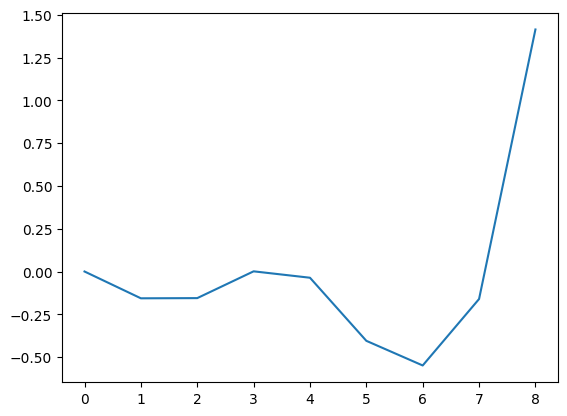

In [16]:
# %pip install scikit-learn
from sklearn.linear_model import LinearRegression

#shotdf[shotdf['h_a']=='h']['IsHome'] = 1
X = shotdf[['minute','IsHome','ScoredEarlier','MyScore','OppScore','WinProb','LoseProb','PrevAccumXG']]
y = shotdf['ScaledIsGoal']


model = LinearRegression()
model.fit(X, y)
model_numbers = (list(model.coef_) + [model.intercept_])
plt.plot(model_numbers)

first_shot = (shotdf.iloc[[0]][['minute','IsHome','ScoredEarlier','MyScore','OppScore','WinProb','LoseProb','PrevAccumXG']] )
print(first_shot)
print(model.predict( first_shot))

In [17]:
aware_coefficient = model.predict(shotdf[['minute','IsHome','ScoredEarlier','MyScore','OppScore','WinProb','LoseProb','PrevAccumXG']])
shotdf['AwareXG'] = shotdf['xG']*aware_coefficient
shotdf[['xG','AwareXG']].head(20)

#plt.plot(sorted(aware_coefficient))

,xG,AwareXG
1,0.117455,0.124379
2,0.089049,0.094401
4,0.050258,0.051597
7,0.055931,0.047912
10,0.535518,0.563900
11,0.050612,0.039534
12,0.096891,0.081995
15,0.282761,0.259532
16,0.076032,0.056295
18,0.085572,0.062818


# Zastareo kod

In [18]:
raise Exception

Exception: 

In [ ]:
xg_if_scored_earlier = 0
xg_if_scored_later = 0
total_xg = 0
scored_if_scored_earlier = 0
scored_if_scored_later = 0
total_shots = len(all_player_shot_data)
total_goals = 0
for shot in all_player_shot_data:
    if shot['IsGoal']:
        total_goals+=1
        if shot['ScoredEarlier']==1:
            scored_if_scored_earlier+=1
        if shot['ScoredLater']==1:
            scored_if_scored_later+=1
    if shot['ScoredEarlier']==1:
        xg_if_scored_earlier+=float(shot['xG'])
    if shot['ScoredLater']==1:
        xg_if_scored_later+=float(shot['xG'])
    total_xg += float(shot['xG'])

print(scored_if_scored_earlier, scored_if_scored_later)
print(xg_if_scored_earlier, xg_if_scored_later)
ratio_if_scored_earlier = scored_if_scored_earlier / xg_if_scored_earlier
ratio_if_scored_later = scored_if_scored_later / xg_if_scored_later
ratio_total = total_goals / total_xg
print(f'{ratio_if_scored_earlier=} {ratio_if_scored_later=} {ratio_total=}')

NameError: name 'all_player_shot_data' is not defined

In [ ]:
# print([ lis['id'] for lis in (match_dic[('2015-02-07 15:00:00', 'Leicester', 'Crystal Palace')]) ])
# print([ lis['id'] for lis in (match_dic[('2014-10-04 15:00:00', 'Leicester', 'Burnley')]) ] )

# 'h_team': 'Leicester', 'a_team': 'Burnley', 'h_goals': '2', 'a_goals': '2', 'date': '2014-10-04 15:00:00'


In [ ]:
from functools import reduce
def get_xg_and_goals_for_condition_combination(shot_data, condition_dic):
    keys = list(condition_dic.keys())
    vals = list(condition_dic.values())

    conditional_xg = 0
    conditional_goals = 0

    for shot in shot_data:
        # if len(args)==0 or reduce((lambda x, y: x and y), [shot[arg] for arg in args]):
        if vals == [shot[arg] for arg in keys]:
            conditional_xg += float(shot['xG'])
            conditional_goals += int(shot['IsGoal'])
    return conditional_xg, conditional_goals
print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'ScoredEarlier': True}) )

# 'State' nije dobar. otkomentarisi ovo kad iskoristis match data da 

# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'ScoredEarlier': True ,'State': 'winning'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'ScoredEarlier': True ,'State': 'tied'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'ScoredEarlier': True ,'State': 'losing'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'State': 'winning'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'State': 'tied'}))
# print(get_xg_and_goals_for_condition_combination(all_player_shot_data, {'State': 'losing'}))

(1016.7205622913316, 931)


In [ ]:
[1,2]==[True,2]

True

In [ ]:
print(all_player_shot_data[0])

{'id': '52025', 'minute': '3', 'result': 'BlockedShot', 'X': '0.7830000305175782', 'Y': '0.5209999847412109', 'xG': '0.051129300147295', 'player': 'Tom Davies', 'h_a': 'h', 'player_id': '1042', 'situation': 'OpenPlay', 'season': '2015', 'shotType': 'RightFoot', 'match_id': '453', 'h_team': 'Everton', 'a_team': 'Norwich', 'h_goals': '3', 'a_goals': '0', 'date': '2016-05-15 18:00:00', 'player_assisted': 'Kieran Dowell', 'lastAction': 'LayOff', 'ScoredEarlier': 0, 'ScoredPenEarlier': 0, 'ScoredLater': 0, 'ScoredPenLater': 0, 'IsGoal': False}


# Treba da se odradi game state, znaci da li je u trenutku suta taj tim gubio, pobedjivao ili su bili izjednaceni.
Treba u recniku match_data napraviti hronoloski sortiranu listu suteva (koristeci id) koji su ispali golovi.  onda kad se to zavrsi da se vratimo u shot data i da napravimo jos jednu kolonu / key. ovo ovako mora zato sto je shot data prvenstveno sortiran po igracu pa tek onda po vremenu. Treba koristiti match_id i shot_id sto vise, i cinjenicu da je 0-10 puta u istoriji (jako retko lupam brojeve) dato vise golova u istom minutu (sto je dovoljno da ne utice na podatke)

In [ ]:
understat.match('22009').get_shot_data()



{'h': [{'id': '549079',
   'minute': '0',
   'result': 'BlockedShot',
   'X': '0.8590000152587891',
   'Y': '0.2879999923706055',
   'xG': '0.038173574954271317',
   'player': 'Reece James',
   'h_a': 'h',
   'player_id': '8067',
   'situation': 'OpenPlay',
   'season': '2023',
   'shotType': 'RightFoot',
   'match_id': '22009',
   'h_team': 'Chelsea',
   'a_team': 'Manchester City',
   'h_goals': '4',
   'a_goals': '4',
   'date': '2023-11-12 16:30:00',
   'player_assisted': 'Cole Palmer',
   'lastAction': 'BallTouch'},
  {'id': '549080',
   'minute': '11',
   'result': 'BlockedShot',
   'X': '0.8909999847412109',
   'Y': '0.3129999923706055',
   'xG': '0.04885943979024887',
   'player': 'Cole Palmer',
   'h_a': 'h',
   'player_id': '8497',
   'situation': 'OpenPlay',
   'season': '2023',
   'shotType': 'LeftFoot',
   'match_id': '22009',
   'h_team': 'Chelsea',
   'a_team': 'Manchester City',
   'h_goals': '4',
   'a_goals': '4',
   'date': '2023-11-12 16:30:00',
   'player_assisted'

In [ ]:

# match_dic = {}
# def create_match_dic(row):
#     match_dic[(row['date'], row['h_team'], row['a_team'])] = match_dic.get((row['date'], row['h_team'], row['a_team']),[]) + [row]

# shotdf.apply( func = create_match_dic, axis=0)

# print(shotdf.head(10))

# print(list(match_dic.values())[:10])
# for val in match_dic.values():
#     val.sort(key = lambda row : row['minute'])





In [ ]:
(shotdf[shotdf['date']=='2019-08-24 15:00:00'] ).sort_values(by=['h_team','minute']).to_csv('this_date.csv')